In [8]:
import pandas as pd
import shap
import eli5
import matplotlib.pyplot as plt
import plotly.express as px
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import spacy
import pickle

In [11]:
data=pd.read_csv('amazon_alexa.tsv', sep='\t')


In [12]:
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1

In [13]:
data.describe()

rating     feedback
count  3150.000000  3150.000000
mean      4.463175     0.918413
std       1.068506     0.273778
min       1.000000     0.000000
25%       4.000000     1.000000
50%       5.000000     1.000000
75%       5.000000     1.000000
max       5.000000     1.000000

In [14]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [15]:
data['review_length']=data['verified_reviews'].apply(len)
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  review_length  
0                                      Love my Echo!         1             13  
1                                          Loved it!         1              9  
2  Sometimes while playing a game, you can answer...         1            195  
3  I have had a lot of fun with this thing. My 4 ...         1            172  
4                                              Music         1              5

In [16]:
ratings=data['rating'].value_counts()

fig = px.funnel_area(names=ratings.index,
                    values=ratings.values,
                    title='Distribution of Alexa Ratings')
fig.show()

In [17]:
feedback=data['feedback'].value_counts()
fig = px.pie(df, values=feedback.values, names=feedback.index,
            title='Distribution of Feedback')
fig.show()

In [18]:
reviews=px.histogram(data,x="review_length",title='Distribution of Length of Reviews',labels={"review_length":"Review Length"})
reviews.show()

In [19]:
reviews=px.histogram(data,x="review_length",color='feedback',title='Distribution of Length of Reviews by Feedback',labels={"review_length":"Review Length"})
reviews.show()

In [56]:
fig = px.bar(data, x="rating", y="review_length") 
fig.show()

In [36]:

nlp = spacy.blank('en')

In [60]:
data['new_reviews'] = data['verified_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['new_reviews'].head()

0                                        love my echo!
1                                            loved it!
2    sometimes while playing a game, you can answer...
3    i have had a lot of fun with this thing. my 4 ...
4                                                music
Name: new_reviews, dtype: object

In [61]:
data['new_reviews'] = data['new_reviews'].str.replace('[^\w\s]','')
data['new_reviews'].head()

<ipython-input-61-51cf1695e703>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



0                                         love my echo
1                                             loved it
2    sometimes while playing a game you can answer ...
3    i have had a lot of fun with this thing my 4 y...
4                                                music
Name: new_reviews, dtype: object

In [62]:
stop = stopwords.words('english')
data['new_reviews'] = data['new_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['new_reviews'].sample(30)

520     refurbished item finebut wasnt aware fee echos...
2673    really happy original echo thought id get echo...
1222    one favorite amazon devices one bedroom use al...
2542                                          pretty cool
11      love learning knew things eveyday still figuri...
2784                                   loved exactly says
115     45 5 stars generally like product great ask li...
165                                              easy set
2391                                     worth every cent
84                                             works fine
2319                               doesnt turn television
2967               love use everything part daily routine
2242                                              perfect
1029                                                 love
2436                                                     
56             works advertised easy setup still learning
380                    six words 34alexa tell poop joke34
741     like s

In [66]:
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [67]:
def text_cleaning(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in list(spacy.lang.en.stop_words.STOP_WORDS)+list(string.punctuation)]
    return ' '.join(text)

In [68]:
data['new_reviews'] = data['new_reviews'].apply(lambda x: text_cleaning(x))

In [69]:
data['sentiment'] = np.where(data['rating']>= 4, 'Positive', 'Negative')

In [70]:
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  review_length  \
0                                      Love my Echo!         1             13   
1                                          Loved it!         1              9   
2  Sometimes while playing a game, you can answer...         1            195   
3  I have had a lot of fun with this thing. My 4 ...         1            172   
4                                              Music         1              5   

                                         new_reviews sentiment  
0                                          love echo  Positive  
1                                              loved  Positive  
2  playing game answer question correctly alexa s...  Positive  
3  lot fun thing 4 yr old learns dinosaur control...  Positive  
4                                              music  Positive

In [46]:
pip install vaderSentiment

In [47]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss

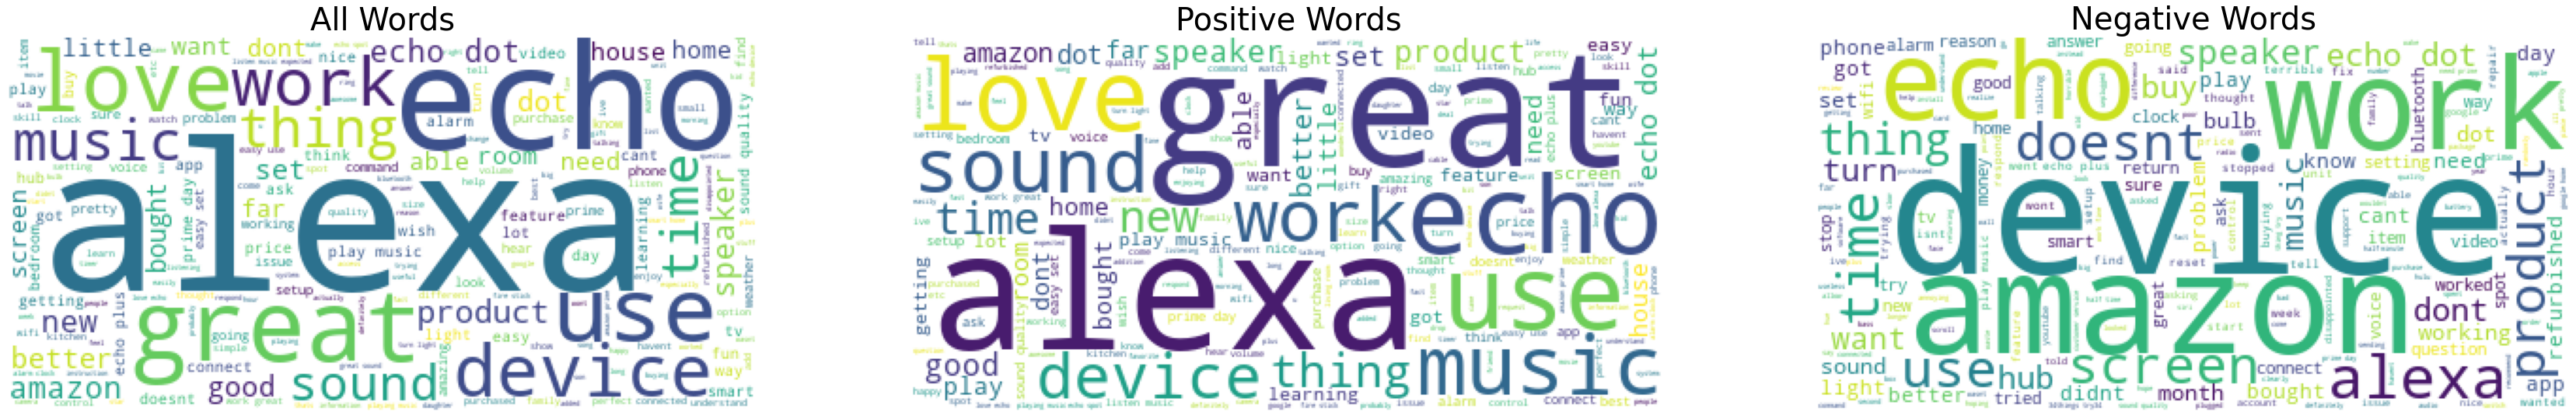

In [89]:
from wordcloud import WordCloud

All_word = ''.join(data['new_reviews'].tolist()) # All words in the given corpus
positive_words = ''.join(data[data['feedback']==1]['new_reviews'].tolist()) # All positive words
negative_words = ''.join(data[data['feedback']==0]['new_reviews'].tolist()) # All negative words
category = ['All Words','Positive Words','Negative Words']
data_wordcloud = [All_word,positive_words,negative_words]

plt.figure(figsize=(80,80))
for i in range(0,3):
    t=i+1
    plt.subplot(5, 4, t).set_title(category[i],fontsize=40)
    plt.axis('off')
    plt.imshow(WordCloud(background_color='white').generate(data_wordcloud[i]))
#plt.savefig('Wordcloud.png')
plt.show()

In [75]:
count_dict_alex = {}

for doc in data['new_reviews']:
    for word in doc.split():
        if word in count_dict_alex.keys():
            count_dict_alex[word] +=1
        else:
            count_dict_alex[word] = 1
            
for key, value in sorted(count_dict_alex.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

dinosaur: 1
category: 1
grandaughter: 1
2000: 1
mile: 1
timermusic: 1
duty: 1
boost: 1
definitively: 1
input: 1
select: 1
encyclopedia: 1
greatit: 1
thermostatand: 1
lightswithout: 1
chair: 1
pattern: 1
promp: 1
poop: 1
joke34: 1
naw: 1
outsmart: 1
youll: 1
echosecho: 1
performing: 1
6th: 1
divertido: 1
1000: 1
speaknspell: 1
iove: 1
attach: 1
soundgood: 1
fm: 1
native: 1
texas: 1
birth: 1
additionally: 1
marginal: 1
extender: 1
dust: 1
collector: 1
34fixes34: 1
accomplished: 1
34never: 1
34certified: 1
acknowledge: 1
indicated: 1
perfectlyvery: 1
productsand: 1
journey: 1
daytoday: 1
surely: 1
portion: 1
leary: 1
puny: 1
wear: 1
tear: 1
shuts: 1
mint: 1
teenager: 1
insist: 1
dinneras: 1
lifechanging: 1
young: 1
simplicity: 1
gazebo: 1
sortof: 1
complaini: 1
timework: 1
diagnostics: 1
corrected: 1
roomba: 1
reboot: 1
sentence: 1
holding: 1
onehonestly: 1
productonce: 1
itthis: 1
shocked: 1
clone: 1
boat: 1
garage: 1
loli: 1
gf: 1
intermittently: 1
pulsate: 1
pulsed: 1
buddy: 1
easierth

pool: 5
worry: 5
changing: 5
iheartradio: 5
simultaneously: 5
hesitant: 5
greatest: 5
pain: 5
pleasure: 5
weak: 5
kinda: 5
hoped: 5
installing: 5
inconvenient: 5
auxiliary: 5
prefer: 5
nest: 5
phillips: 5
leaving: 5
shipping: 5
background: 5
guest: 5
buck: 5
flawlessly: 5
complain: 5
horrible: 5
unplug: 5
certified: 5
refurb: 5
disconnect: 5
buyer: 5
recommended: 5
effort: 5
helping: 5
appointment: 5
application: 5
shouldnt: 5
level: 5
warranty: 5
special: 5
chance: 5
true: 5
sense: 5
form: 5
alert: 5
chose: 5
opinion: 5
neat: 5
recording: 5
intended: 5
grand: 5
date: 5
shop: 5
l: 5
weekend: 5
facetime: 5
bring: 5
negative: 5
remember: 5
compared: 5
asleep: 5
rid: 5
effective: 5
trailer: 5
paired: 5
website: 5
pair: 5
alex: 5
privacy: 5
happened: 5
imagine: 5
skype: 5
general: 5
clean: 5
addicted: 5
ad: 5
swipe: 5
mic: 5
cutting: 5
felt: 5
updated: 5
suppose: 5
silly: 5
liking: 5
debating: 5
concern: 5
rotate: 5
medium: 5
thunderstorm: 5
willing: 5
nearly: 5
web: 5
mind: 5
library: 5
p

In [76]:
value = 10
remove_words = [key for key in count_dict_alex.keys() if count_dict_alex[key] < value]

In [77]:
corpus = [doc.split() for doc in data['new_reviews']]
clean_list = []
for document in corpus:
    clean_list.append([word for word in document if word not in remove_words])

In [78]:
clean_list

[['love', 'echo'],
 ['loved'],
 ['playing',
  'game',
  'answer',
  'question',
  'correctly',
  'alexa',
  'say',
  'got',
  'wrong',
  'answer',
  'like',
  'able',
  'turn',
  'light',
  'away',
  'home'],
 ['lot',
  'fun',
  'thing',
  '4',
  'old',
  'control',
  'light',
  'play',
  'game',
  'like',
  'nice',
  'sound',
  'playing',
  'music'],
 ['music'],
 ['received',
  'echo',
  'gift',
  'needed',
  'bluetooth',
  'play',
  'music',
  'easily',
  'found',
  'smart',
  'speaker',
  'cant',
  'wait'],
 ['use',
  'feature',
  'use',
  'great',
  'alarm',
  'u',
  'hear',
  'alarm',
  'bedroom',
  'living',
  'room',
  'reason',
  'fun',
  'ask',
  'question',
  'hear',
  'response'],
 ['think',
  'ive',
  'purchased',
  'im',
  'working',
  'getting',
  'room',
  'house',
  'like',
  'feature',
  'offer',
  'playing',
  'music',
  'echo',
  'light',
  'house'],
 ['look', 'great'],
 ['love',
  'ive',
  'song',
  'havent',
  'heard',
  'news',
  'weather',
  'information',
  'gre

In [79]:
corpus=[]
for item in clean_list:
    item = ' '.join(item)
    corpus.append(item)
    
corpus

['love echo',
 'loved',
 'playing game answer question correctly alexa say got wrong answer like able turn light away home',
 'lot fun thing 4 old control light play game like nice sound playing music',
 'music',
 'received echo gift needed bluetooth play music easily found smart speaker cant wait',
 'use feature use great alarm u hear alarm bedroom living room reason fun ask question hear response',
 'think ive purchased im working getting room house like feature offer playing music echo light house',
 'look great',
 'love ive song havent heard news weather information great',
 'sent year old dad talk constantly',
 'love learning knew thing work far easy use understand laugh time',
 'purchased mother problem trying come getting fast like little big thing play song time',
 'love love love',
 'expected',
 'love wife',
 'happy purchase great speaker easy set',
 'alexa couple day lot fun new toy like new household trying learn different come',
 'love size 2nd generation echo need little i

In [171]:
#pip install gensim

In [84]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [85]:
clean_list[0][:5]

['love', 'echo']

In [86]:
corpora_dict = corpora.Dictionary(clean_list)
corpus = [corpora_dict.doc2bow(line) for line in clean_list]

In [88]:
#we will build a model with 3 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [87]:
lda_model = LdaModel(corpus=corpus,
                         id2word=corpora_dict,
                         random_state=100,
                         num_topics=3,
                         passes=5,
                         per_word_topics=True)

# See the topics
lda_model.print_topics(-1)

[(0,
  '0.090*"love" + 0.048*"work" + 0.043*"great" + 0.037*"easy" + 0.028*"like" + 0.025*"use" + 0.024*"product" + 0.020*"alexa" + 0.020*"good" + 0.017*"tv"'),
 (1,
  '0.024*"use" + 0.024*"music" + 0.024*"device" + 0.023*"alexa" + 0.021*"great" + 0.020*"sound" + 0.019*"time" + 0.018*"speaker" + 0.018*"set" + 0.016*"play"'),
 (2,
  '0.060*"echo" + 0.030*"dot" + 0.027*"love" + 0.026*"music" + 0.023*"like" + 0.018*"alexa" + 0.015*"great" + 0.013*"amazon" + 0.012*"new" + 0.011*"light"')]

In [91]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
import gensim.downloader as api

In [95]:
dct = corpora.Dictionary(clean_list)
corpus = [dct.doc2bow(line) for line in clean_list]
bigram = gensim.models.phrases.Phrases(clean_list, min_count=3, threshold=10)

print(bigram[clean_list[6]])

['use', 'feature', 'use', 'great', 'alarm', 'u', 'hear', 'alarm', 'bedroom', 'living_room', 'reason', 'fun', 'ask_question', 'hear', 'response']


###### VADER belongs to a kind of sentiment analysis that depends on lexicons of sentiment-related words. In this methodology, every one of the words in the vocabulary is appraised with respect to whether it is positive or negative, and, how +ve or -ve

In [96]:
analyser = SentimentIntensityAnalyzer()


In [97]:
def sentimentScore(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        print(str(vs))
        results.append(vs) 
    return results

In [98]:
sentiment = sentimentScore(data['new_reviews'])

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5994}
{'neg': 0.152, 'neu': 0.637, 'pos': 0.211, 'compound': 0.0516}
{'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'compound': 0.8957}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.49, 'pos': 0.51, 'compound': 0.8555}
{'neg': 0.145, 'neu': 0.633, 'pos': 0.223, 'compound': 0.5574}
{'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.5106}
{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.8519}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'compound': 0.8934}
{'neg': 0.104, 'neu': 0.579, 'pos': 0.317, 'compound': 0.6705}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9274}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.416, 'neu': 0.112, 'pos': 0.472, 'compound': 0.128}
{'neg': 0.0, 'neu': 0.219, 'pos': 0.781, 'compound

{'neg': 0.05, 'neu': 0.663, 'pos': 0.288, 'compound': 0.8885}
{'neg': 0.0, 'neu': 0.522, 'pos': 0.478, 'compound': 0.6705}
{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'compound': 0.8402}
{'neg': 0.114, 'neu': 0.777, 'pos': 0.109, 'compound': -0.0258}
{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'compound': 0.9222}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'compound': 0.9139}
{'neg': 0.144, 'neu': 0.446, 'pos': 0.409, 'compound': 0.8779}
{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'compound': 0.8979}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.099, 'neu': 0.594, 'pos': 0.306, 'compound': 0.9271}
{'neg': 0.0, 'neu': 0.407, 'pos': 0.593, 'compound': 0.9549}
{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compou

{'neg': 0.133, 'neu': 0.611, 'pos': 0.256, 'compound': 0.9668}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}
{'neg': 0.23, 'neu': 0.492, 'pos': 0.279, 'compound': 0.1531}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'compound': 0.5859}
{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
{'neg': 0.145, 'neu': 0.606, 'pos': 0.248, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 

In [99]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df.head()

neg    neu    pos  compound
0  0.000  0.192  0.808    0.6369
1  0.000  0.000  1.000    0.5994
2  0.152  0.637  0.211    0.0516
3  0.000  0.504  0.496    0.8957
4  0.000  1.000  0.000    0.0000

In [102]:
data.index = sentiment_df.index
sentiment_df['rating'] = data['rating']
data_vader = pd.concat([data, sentiment_df], axis=1)
data_vader.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  review_length  \
0                                      Love my Echo!         1             13   
1                                          Loved it!         1              9   
2  Sometimes while playing a game, you can answer...         1            195   
3  I have had a lot of fun with this thing. My 4 ...         1            172   
4                                              Music         1              5   

                                         new_reviews sentiment    neg    neu  \
0                                          love echo  Positive  0.000  0.192   
1                                              loved  Positive  0.000  0.000   
2  playing game answer question correctly alexa s...  Positive  0.152  0.637   
3  lot fun thing 4 yr old learns dinosaur control...  Positive  0.000  0.504   
4                                              music  Positive  0.000  1.000   

     pos  compound  rating  
0  0.808    0.6369       5  
1  1.000    0.5994       5  
2  0.211    0.0516       4  
3  0.496    0.8957       5  
4  0.000    0.0000       5

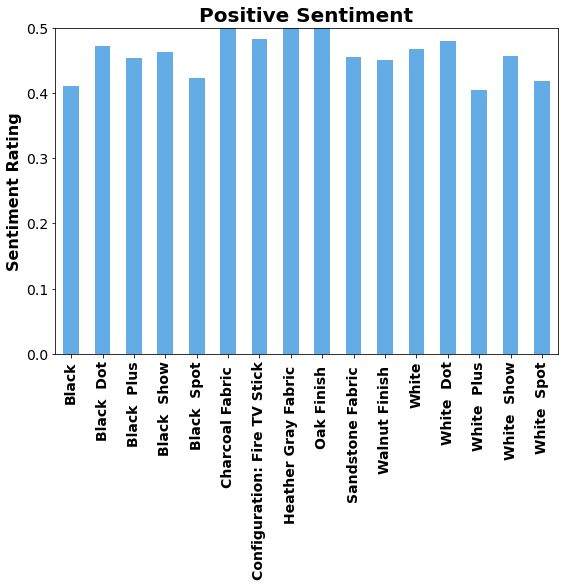

<Figure size 432x288 with 0 Axes>

In [111]:
color = ['#63ace5']
ax = data_vader.groupby("variation").pos.mean().plot.bar(color = color, figsize = (9, 6))

plt.title('Positive Sentiment', fontsize = 20, weight='bold')

plt.xticks(rotation='90', fontsize=14, weight='bold')
ax.xaxis.label.set_visible(False)

plt.ylabel('Sentiment Rating', fontsize=16, weight='bold')
ax.set_ylim([0,0.5])
plt.yticks(fontsize=14)
fig = plt.gcf()
plt.show()
plt.draw()

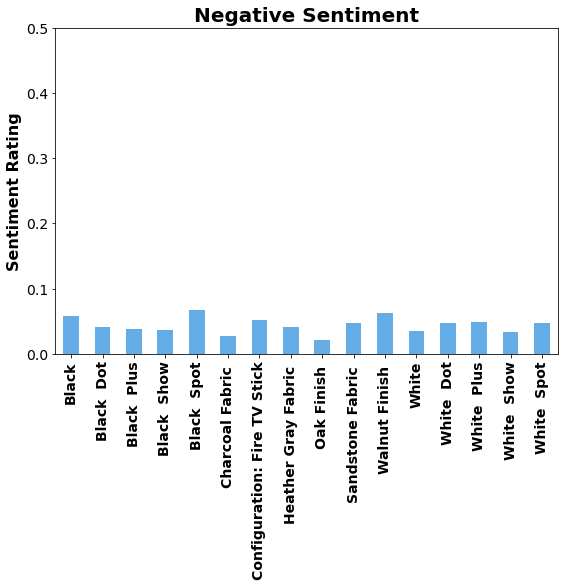

<Figure size 432x288 with 0 Axes>

In [113]:
color = ['#63ace5']
ax = echo_vader.groupby("variation").neg.mean().plot.bar(color = color, figsize = (9, 6))

plt.title('Negative Sentiment', fontsize = 20, weight='bold')
plt.xticks(rotation='90', fontsize=14, weight='bold')
ax.xaxis.label.set_visible(False)

plt.ylabel('Sentiment Rating', fontsize=16, weight='bold')
ax.set_ylim([0,0.5])
plt.yticks(fontsize=14)
fig = plt.gcf()
plt.show()
plt.draw()

In [114]:
reviews = data['new_reviews']
feedback = data['feedback']

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,confusion_matrix

In [118]:
xtrain,xtest,ytrain,ytest = train_test_split(reviews,feedback,test_size=0.2,random_state=45)

#### A bag of words is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. 
#### TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus.

In [119]:
#Creating dataset for Bag of word model
countvect = CountVectorizer()
review_train_vectorize = countvect.fit_transform(xtrain)
review_test_vectorize = countvect.transform(xtest)

#Creating dataset for TFIDF model
tfidf_transform = TfidfTransformer()
review_train_tfidf = tfidf_transform.fit_transform(review_train_vectorize)
review_test_tfidf = tfidf_transform.transform(review_test_vectorize)

In [121]:
#Bow model
nb = MultinomialNB()
nb.fit(review_train_vectorize,ytrain)
y_pred_vect = nb.predict(review_test_vectorize)
print(classification_report(ytest,y_pred_vect))
print(f'Accuracy:{accuracy_score(ytest,y_pred_vect)}')
print(f'AUC ROC :{roc_auc_score(ytest,y_pred_vect)}')

              precision    recall  f1-score   support

           0       0.69      0.18      0.28        51
           1       0.93      0.99      0.96       579

    accuracy                           0.93       630
   macro avg       0.81      0.58      0.62       630
weighted avg       0.91      0.93      0.91       630

Accuracy:0.926984126984127
AUC ROC :0.584781062684141


In [128]:
#TFIDF model
nb.fit(review_train_tfidf,ytrain)
ypred_nb_tfidf = nb.predict(review_test_tfidf)
print(classification_report(ytest,ypred_nb_tfidf))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_nb_tfidf)}')
print(f'AUCROC Score:{roc_auc_score(ytest,ypred_nb_tfidf)}')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.92      1.00      0.96       579

    accuracy                           0.92       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.92      0.88       630

Accuracy Score:0.919047619047619
AUCROC Score:0.5


C:\Users\tfclmr31\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\tfclmr31\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\tfclmr31\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [136]:
#Bow model
svm = SVC(kernel='linear')
svm.fit(review_train_vectorize,ytrain)
ypred_vect_svm = svm.predict(review_test_vectorize)
print(classification_report(ytest,ypred_vect_svm))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_vect_svm)}')
print(f'AUC ROC Score:{roc_auc_score(ytest,ypred_vect_svm)}')

              precision    recall  f1-score   support

           0       0.62      0.57      0.59        51
           1       0.96      0.97      0.97       579

    accuracy                           0.94       630
   macro avg       0.79      0.77      0.78       630
weighted avg       0.93      0.94      0.94       630

Accuracy Score:0.9365079365079365
AUC ROC Score:0.7687696840394188


In [137]:
#TFIDF model
svm.fit(review_train_tfidf,ytrain)
ypred_tfidf_svm = svm.predict(review_test_tfidf)
print(classification_report(ytest,ypred_tfidf_svm))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_tfidf_svm)}')
print(f'AUC ROC Score:{roc_auc_score(ytest,ypred_tfidf_svm)}')

              precision    recall  f1-score   support

           0       0.73      0.16      0.26        51
           1       0.93      0.99      0.96       579

    accuracy                           0.93       630
   macro avg       0.83      0.58      0.61       630
weighted avg       0.91      0.93      0.90       630

Accuracy Score:0.926984126984127
AUC ROC Score:0.57584069897389


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Attribute intercept_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).


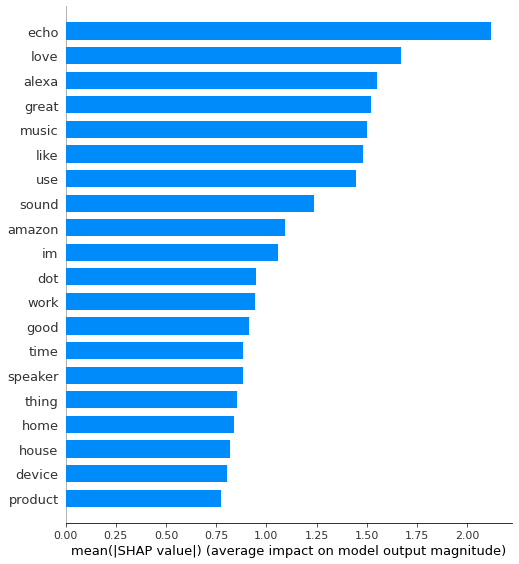

In [133]:
explainer = shap.LinearExplainer(nb,review_train_vectorize,feature_dependence='independent')
shap_values = explainer.shap_values(review_test_vectorize)
review_test_vectorize_array = review_test_vectorize.toarray()
shap.summary_plot(shap_values,review_test_vectorize_array,feature_names=countvect.get_feature_names(),plot_type='bar',layered_violin_max_num_bins=20)

In [135]:
def get_row_index(ytest,row_number):
    t_text = ytest.reset_index()
    return t_text['index'][row_number]

i=8
print('Predicted Review:', "Positive" if ytest.iloc[i] else "Negative")
print('Actual Review:',reviews[get_row_index(ytest,i)])
shap.force_plot(explainer.expected_value,shap_values[i,:],review_test_vectorize_array[i,:],feature_names=countvect.get_feature_names())

Predicted Review: Positive
Actual Review: purchased mother knee problem trying come getting fast like didshe enjoys little big thing doalexa play song time cook


In [143]:
eli5.show_prediction(svm,xtest[get_row_index(ytest,i)],vec=countvect,target_names=ytest)

### DEEP LEARNING

In [146]:
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,AUC
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.utils import plot_model,to_categorical
from keras_tqdm import TQDMNotebookCallback,TQDMCallback
from tqdm import autonotebook

In [145]:
#pip install keras_tqdm

Note: you may need to restart the kernel to use updated packages.


In [149]:
epoch = 15
batch_size = 64

n_unique_words = 10000
n_dim = 64
max_input_len = 100
drop_emb = 0.3

n_lstm = 128
drop_lstm = 0.2

In [148]:
X = data['new_reviews']
y = data['feedback']

In [150]:
xtrain, xval, ytrain, yval = train_test_split(X,y,test_size=0.2,random_state=45)

In [151]:
tokenizer = Tokenizer(n_unique_words+1)
tokenizer.fit_on_texts(xtrain)

xtrain = tokenizer.texts_to_sequences(xtrain)
xval = tokenizer.texts_to_sequences(xval)

In [152]:
xtrain_seq = sequence.pad_sequences(xtrain,maxlen=max_input_len)
xval_seq = sequence.pad_sequences(xval,maxlen=max_input_len)

In [153]:
ytrain = np.array(ytrain)  
yval = np.array(yval)

#### Bi-directional LSTM Architecture

In [154]:
model = Sequential()
model.add(Embedding(n_unique_words,n_dim,input_length=max_input_len))
model.add(SpatialDropout1D(drop_emb))
model.add(Bidirectional(LSTM(n_lstm,recurrent_dropout=drop_lstm)))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 64)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 837,889
Trainable params: 837,889
Non-trainable params: 0
_________________________________________________________________


In [156]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [160]:
model_hist = model.fit(x=xtrain_seq,
                       y=ytrain,
                       validation_split=0.1,
                       batch_size=batch_size,
                       epochs=epoch,
                       verbose=0)

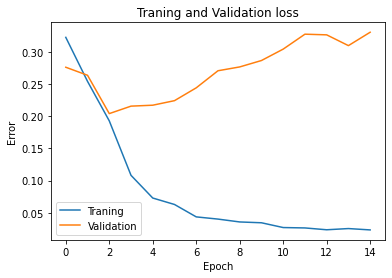

In [161]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('Traning and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Traning','Validation'])
plt.show()

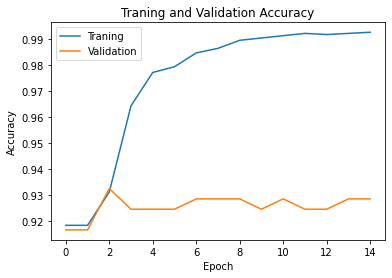

In [162]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Traning','Validation'])
plt.show()

In [163]:

Score= model.evaluate(xval_seq,yval,verbose=0,callbacks=[TQDMNotebookCallback(leave_outer=True,show_outer=True, show_inner=False)])
print(f'Loss:{Score[0]}')
print(f'Accuracy:{Score[1]}')
y_pred_model = model.predict(xval_seq)
print('AUC-ROC Score:',roc_auc_score(yval,y_pred_model.ravel()))
print(classification_report(yval,y_pred_model.ravel().round()))

Loss:0.2612857520580292
Accuracy:0.9492063522338867
AUC-ROC Score: 0.8915134274780724
              precision    recall  f1-score   support

           0       0.79      0.51      0.62        51
           1       0.96      0.99      0.97       579

    accuracy                           0.95       630
   macro avg       0.87      0.75      0.80       630
weighted avg       0.94      0.95      0.94       630



#### Multi Convolutional Layer

In [164]:
input_layer = Input(shape = (max_input_len,),dtype='int16',name='input_Layer')

embedding_layer = Embedding(n_unique_words,n_dim,input_length=max_input_len,name='Embedding_layer')(input_layer)
drop_embedding_layer = SpatialDropout1D(0.3,name='Drop_Embedding_Layer')(embedding_layer)

Conv1 = Conv1D(128,3,activation='relu')(drop_embedding_layer)
maxpool1 = GlobalMaxPool1D(name='Max_Pooling_Layer_1')(Conv1)

Conv2 = Conv1D(128,2,activation='relu')(drop_embedding_layer)
maxpool2 = GlobalMaxPool1D(name='Max_Pooling_Layer_2')(Conv2)

Conv3 = Conv1D(128,4,activation='relu')(drop_embedding_layer)
maxpool3 = GlobalMaxPool1D(name='Max_Pooling_Layer_3')(Conv3)

concat = concatenate([maxpool1,maxpool2,maxpool3])
    
dense_layer = Dense(64,activation='relu',name = 'Dense_Layer')(concat)
drop_dense_layer = Dropout(0.3,name='Drop_Dense_Layer')(dense_layer)

Prediction = Dense(1,activation='sigmoid',name = 'Prediction')(drop_dense_layer)

model_custom = Model(input_layer,Prediction)

In [165]:
model_custom.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_Layer (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 Embedding_layer (Embedding)    (None, 100, 64)      640000      ['input_Layer[0][0]']            
                                                                                                  
 Drop_Embedding_Layer (SpatialD  (None, 100, 64)     0           ['Embedding_layer[0][0]']        
 ropout1D)                                                                                        
                                                                                                  
 conv1d (Conv1D)                (None, 98, 128)      24704       ['Drop_Embedding_Layer[0][0]'

In [166]:
model_custom.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [167]:
model_custom_hist = model_custom.fit(x=xtrain_seq,
                       y=ytrain,
                       validation_split=0.1,
                       batch_size=batch_size,
                       epochs=epoch,
                       verbose=0)

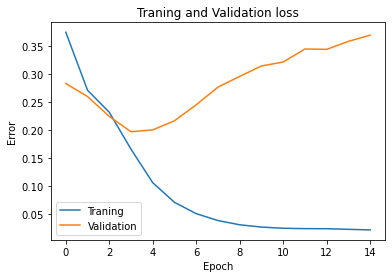

In [168]:
plt.plot(model_custom_hist.history['loss'])
plt.plot(model_custom_hist.history['val_loss'])
plt.title('Traning and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Traning','Validation'])
plt.show()

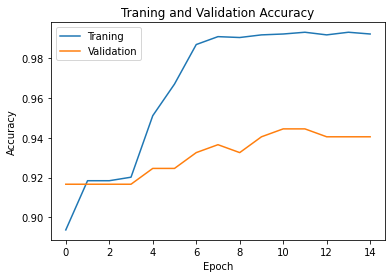

In [169]:
plt.plot(model_custom_hist.history['accuracy'])
plt.plot(model_custom_hist.history['val_accuracy'])
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Traning','Validation'])
plt.show()

In [170]:
Score= model_custom.evaluate(xval_seq,yval,verbose=0,callbacks=[TQDMNotebookCallback(leave_outer=True,show_outer=True, show_inner=False)])
print(f'Loss:{Score[0]}')
print(f'Accuracy:{Score[1]}')
y_pred_cust_model = model_custom.predict(xval_seq)
print('AUC-ROC Score:',roc_auc_score(yval,y_pred_cust_model.ravel()))
print(classification_report(yval,y_pred_cust_model.ravel().round()))

Loss:0.25099512934684753
Accuracy:0.9492063522338867
AUC-ROC Score: 0.9449354871482273
              precision    recall  f1-score   support

           0       0.74      0.57      0.64        51
           1       0.96      0.98      0.97       579

    accuracy                           0.95       630
   macro avg       0.85      0.78      0.81       630
weighted avg       0.95      0.95      0.95       630

